In [1]:
!pip install --quiet transformers[torch] sentencepiece datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cristinaandrade","key":"7ebe8858f4de974e88d87ce12b949f49"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d marlesson/news-of-the-site-folhauol


Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 53% 100M/187M [00:00<00:00, 1.05GB/s]
100% 187M/187M [00:00<00:00, 608MB/s] 


In [6]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

In [7]:
import zipfile

with zipfile.ZipFile("news-of-the-site-folhauol.zip", "r") as zip_ref:
    zip_ref.extractall("folha_dataset")


In [8]:
import pandas as pd

df = pd.read_csv("folha_dataset/articles.csv", parse_dates=["date"], dayfirst=True)
df.head()


,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [9]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtro por seção "mercado' e data entre jan-mar 2015 primeiro trimestre
filtro = (df['category'].str.lower() == 'mercado') & \
         (df['date'].between('2015-01-01', '2015-03-31'))

mercado_df = df.loc[filtro].dropna(subset=['text'])


In [10]:
mercado_df

,title,text,date,category,subcategory,link
99055,Prioridade ao pós-pago reduz número de linhas ...,"O mercado de telefonia celular perdeu 2,09 mil...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99063,Dilma sanciona meta fiscal e governo liberará ...,A presidente Dilma Rousseff sancionou a altera...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99064,Reportagem da Folha sobre investidor mais jove...,"A reportagem da Folha ""Príncipe da Bolsa"", de ...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99074,Impeachment pode prejudicar ajuste fiscal no B...,A abertura do processo de impeachment da presi...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99076,Petrobras anuncia 2º reajuste no preço do gás ...,A Petrobras comunicou ao mercado novo reajuste...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
...,...,...,...,...,...,...
167000,"Em Miami, brasileiros gastam mais com compras ...",Chamam a atenção no caso do Brasil os gastos e...,2015-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
167004,25% dos municípios brasileiros fecharam vagas ...,Cerca de um quarto dos municípios brasileiros ...,2015-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
167013,Brasileiros lideram em número de turistas que ...,"""Em 2013, 51% dos turistas que foram a Miami e...",2015-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
167016,Brasil só vai entrar nos eixos se fizer reform...,Em uma analogia entre a gestão pública e a emp...,2015-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...


In [11]:
ner_pipe = pipeline(
    "ner",
    model="monilouise/ner_news_portuguese",
    tokenizer="monilouise/ner_news_portuguese",
    trust_remote_code=True,
    revision="main",
   aggregation_strategy="simple",
model_kwargs={"use_safetensors": True}

)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monilouise/ner_news_portuguese were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

orgs = []

for texto in mercado_df['text'].dropna():
    if isinstance(texto, str) and texto.strip():
        ents = ner_pipe(texto)
        orgs.extend([ent['word'] for ent in ents if ent['entity_group'] == 'ORG'])


org_freq = Counter(orgs).most_common(10)


if org_freq:
    orgs_list, counts = zip(*org_freq)

    plt.figure(figsize=(10, max(4, len(orgs_list) * 0.25)))
    plt.barh(orgs_list[::-1], counts[::-1])
    plt.title("Ranking top 10 Organizações mencionadas na secao mercado de  primeiro trimestre")
    plt.xlabel("Frequência")
    plt.tight_layout()
    plt.show()
else:
    print(" Nenhuma organização encontrada.")


In [14]:
import re

def limpar(ent):
    """Remove tokens quebrados ou irrelevantes."""
    ent = ent.strip()
    if len(ent) <= 2 or re.match(r'^#+', ent):  # muito curto ou começa com ###
        return None
    if re.fullmatch(r'[A-Za-z]{1,2}', ent):  # tipo 's', 'O', 'B'
        return None
    return ent

In [18]:
from tqdm import tqdm

orgs = []

for texto in tqdm(mercado_df['text'].dropna()):
    if isinstance(texto, str) and texto.strip():
        ents = ner_pipe(texto)
        for ent in ents:
            if ent['entity_group'] == 'ORG':
                nome = limpar(ent['word'])
                if nome:
                    orgs.append(nome)


100%|██████████| 2111/2111 [1:04:01<00:00,  1.82s/it]


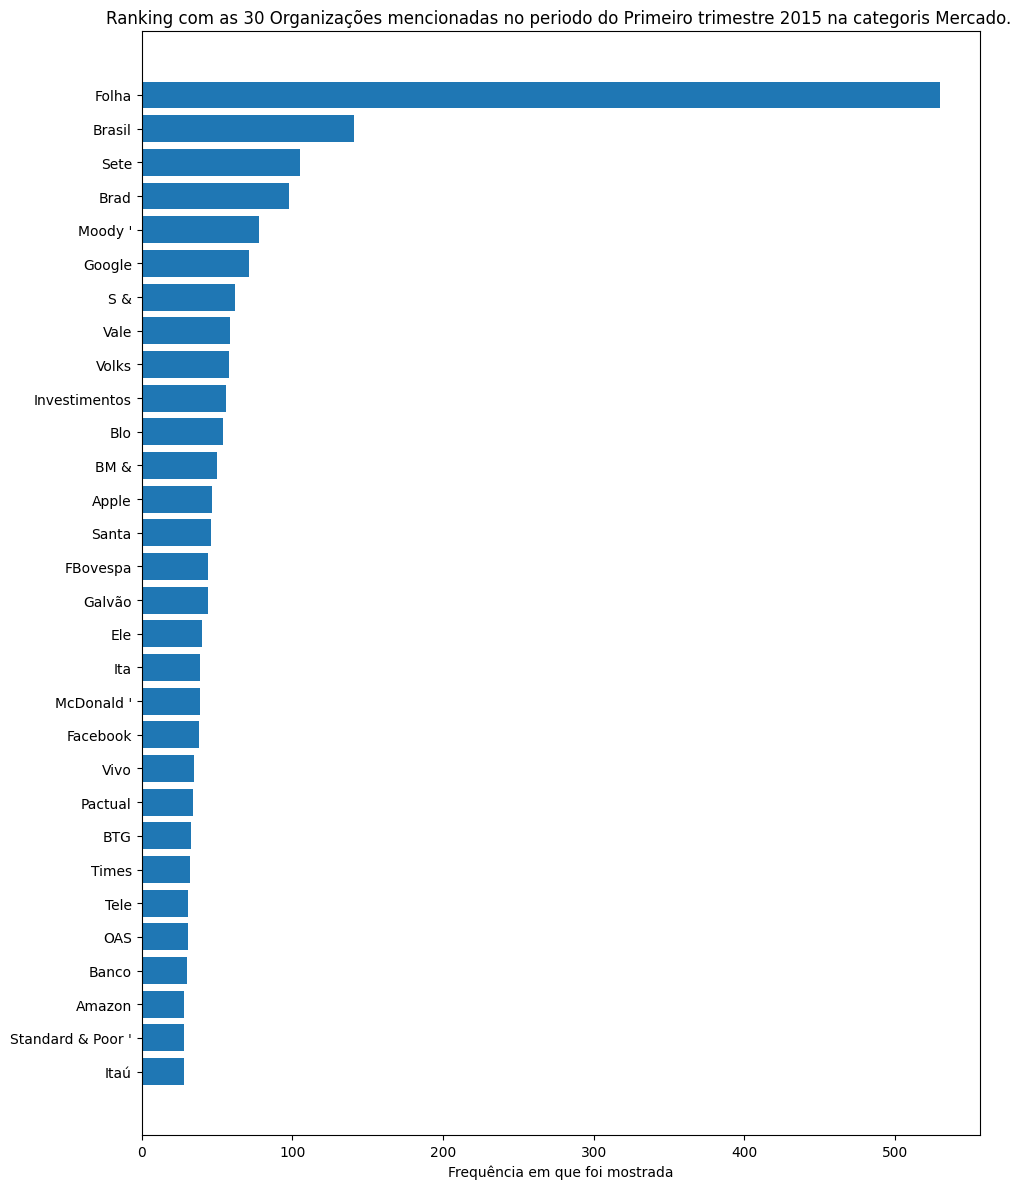

In [24]:
from collections import Counter
import matplotlib.pyplot as plt

# Contar frequência das organizações
org_freq = Counter(orgs).most_common(30)  # top 10

# Verifica se há entidades para evitar erro no zip
if org_freq:
    orgs_list, counts = zip(*org_freq)

    plt.figure(figsize=(10, max(4, len(orgs_list) * 0.4)))
    plt.barh(orgs_list[::-1], counts[::-1])
    plt.title("Ranking com as 30 Organizações mencionadas no periodo do Primeiro trimestre 2015 na categoris Mercado. ")
    plt.xlabel("Frequência em que foi mostrada")
    plt.tight_layout()
    plt.show()
else:
    print(" Nenhuma organização válida encontrada.")
